In [ ]:
#
# Script for comparing WL and FSS
# João Inácio, May 10th, 2021
#

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, linregress

In [2]:
# Simulation parameters

dim = "2D"
lattice = "SS"
NN = 4

L = 8
N_atm = L**2

max_E = (1 / 2) * NN * N_atm
max_M = N_atm
NE = int(1 + (max_E / 2))
NM = N_atm + 1
energies = np.linspace(- max_E, max_E, NE)
magnetizations = np.linspace(- max_M, max_M, NM)

n_run = 100

# WL 
f_final_exp_vals = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11])
f_final_vals = 1 + 10.0**(- f_final_exp_vals)
flatness = 90

# FSS
REP_exp_vals = np.array([3, 4, 5, 6])
REP_vals = 10**REP_exp_vals
skip = N_atm

q_max = (NM + 1) // 2 - 2
if NM % 2 == 0:
    q_max = NM // 2 - 3


In [3]:
# Declaration of arrays

# FSS

JDOS_all_fss = list()
for i in range(len(REP_exp_vals)):
    JDOS_all_fss.append(list())

wall_time_all_fss = np.zeros((n_run, len(REP_exp_vals)))
steps_mean_all_fss = np.zeros((n_run, len(REP_exp_vals)))

cfg_chkbrd_fss = np.zeros((n_run, len(REP_exp_vals)))
cfg_slice_fss = np.zeros((n_run, len(REP_exp_vals)))
cfg_zerozero_fss = np.zeros((n_run, len(REP_exp_vals)))

JDOS_mean_fss = list()
wall_time_mean_fss = list()
steps_mean_fss = list()

#WL 

JDOS_all_wl = list()
for i in range(len(f_final_exp_vals)):
    JDOS_all_wl.append(list())

wall_time_all_wl = np.zeros((n_run, len(f_final_exp_vals)))
steps_mean_all_wl = np.zeros((n_run, len(f_final_exp_vals)))

cfg_chkbrd_wl = np.zeros((n_run, len(f_final_exp_vals)))
cfg_slice_wl = np.zeros((n_run, len(f_final_exp_vals)))
cfg_zerozero_wl = np.zeros((n_run, len(f_final_exp_vals)))

JDOS_mean_wl = list()
wall_time_mean_wl = list()
steps_mean_wl = list()


In [4]:
# Read FSS data

for k, REP_exp in enumerate(REP_exp_vals):
    for run in range(1, n_run + 1):
        file_name = "".join(("./data/fss/L", str(L), "/", str(REP_exp),"/",
                             str(run), "_JDOS_FSS_Ising_", dim, "_", lattice, 
                             "_L", str(L), "_REP_1E", str(REP_exp), 
                             "_skip_", str(skip)))
        JDOS = np.loadtxt(file_name + ".txt")
        JDOS[:, q_max+2:NM] = JDOS[:, range(q_max, -1, -1)]

        cfg_chkbrd_fss[run - 1, k] = JDOS[len(energies) - 1, q_max+1]
        cfg_slice_fss[run - 1, k] = JDOS[L, q_max+1]
        cfg_zerozero_fss[run - 1, k] = JDOS[energies==0, magnetizations==0]

        JDOS_all_fss[k].append(JDOS)

        with open(file_name + "_data.txt", 'r') as data_file:
            header = data_file.readline().strip("\n")            
            for line in data_file:
                if len(line.split()) > 1:
                    steps_mean_all_fss[run - 1, k] += float(line.split()[5])
                else:
                    break
            wall_time_all_fss[run - 1, k] = float(line)
    
    JDOS_mean_fss.append(sum(JDOS_all_fss[k]) / n_run)
    wall_time_mean_fss.append(sum(wall_time_all_fss[:, k]) / n_run)
    steps_mean_fss.append(sum(steps_mean_all_fss[:, k]) / n_run)

# Read WL data

for k, f_final_exp in enumerate(f_final_exp_vals):
    for run in range(1, n_run + 1):
        file_name = "".join(("./data/wl/L", str(L), "/", str(f_final_exp),"/",
                             str(run), "_JDOS_WL_Ising_", dim, "_", lattice, 
                             "_L", str(L), "_f", str(f_final_exp), 
                             "_flatness", str(flatness)))
        JDOS = np.loadtxt(file_name + ".txt")

        cfg_chkbrd_wl[run - 1, k] = JDOS[len(energies) - 1, q_max+1]
        cfg_slice_wl[run - 1, k] = JDOS[L, q_max+1]
        cfg_zerozero_wl[run - 1, k] = JDOS[energies==0, magnetizations==0]

        JDOS_all_wl[k].append(JDOS)

        with open(file_name + "_data.txt", 'r') as data_file:
            header = data_file.readline().strip("\n")            
            for line in data_file:
                if len(line.split()) > 1:
                    steps_mean_all_wl[run - 1, k] += float(line.split()[3])
                else:
                    break
            wall_time_all_wl[run - 1, k] = float(line)
    
    JDOS_mean_wl.append(sum(JDOS_all_wl[k]) / n_run)
    wall_time_mean_wl.append(sum(wall_time_all_wl[:, k]) / n_run)
    steps_mean_wl.append(sum(steps_mean_all_wl[:, k]) / n_run)
    

In [5]:
# Fit normal distributions to configurations - shuffle

fit_chkbrd_fss = np.zeros((len(REP_exp_vals), 2))
fit_slice_fss = np.zeros((len(REP_exp_vals), 2))
fit_zerozero_fss = np.zeros((len(REP_exp_vals), 2))

for k in range(len(REP_exp_vals)):    
    fit_chkbrd_fss[k] = norm.fit(cfg_chkbrd_fss[:, k])
    fit_slice_fss[k] = norm.fit(cfg_slice_fss[:, k])
    fit_zerozero_fss[k] = norm.fit(cfg_zerozero_fss[:, k])
    
fit_chkbrd_wl = np.zeros((len(f_final_exp_vals), 2))
fit_slice_wl = np.zeros((len(f_final_exp_vals), 2))
fit_zerozero_wl = np.zeros((len(f_final_exp_vals), 2))

for k in range(len(f_final_exp_vals)):    
    fit_chkbrd_wl[k] = norm.fit(cfg_chkbrd_wl[:, k])
    fit_slice_wl[k] = norm.fit(cfg_slice_wl[:, k])
    fit_zerozero_wl[k] = norm.fit(cfg_zerozero_wl[:, k])


In [9]:
# Compute configurations error

mean_abs_error_chkbrd_fss = np.zeros(len(REP_vals))
mean_abs_error_slice_fss = np.zeros(len(REP_vals))

mean_error_chkbrd_fss = np.zeros((n_run, len(REP_vals)))
mean_error_slice_fss = np.zeros((n_run, len(REP_vals)))
for k in range(len(REP_vals)):
    mean_abs_error_chkbrd_fss[k] = np.mean(np.abs(cfg_chkbrd_fss[:, k] - 2) / 2)
    mean_abs_error_slice_fss[k] =  np.mean(np.abs(cfg_slice_fss[:, k] - 16) / 16)
    
    for run in range(n_run):
        mean_error_chkbrd_fss[run, k] = (cfg_chkbrd_fss[run, k] - 2) / 2
        mean_error_slice_fss[run, k] = (cfg_slice_fss[run, k] - 16) / 16
    
fit_error_chkbrd_fss = np.zeros((len(REP_vals), 2))
fit_error_slice_fss = np.zeros((len(REP_vals), 2))
for k in range(len(REP_vals)):    
    fit_error_chkbrd_fss[k] = norm.fit(mean_error_chkbrd_fss[:, k])
    fit_error_slice_fss[k] = norm.fit(mean_error_slice_fss[:, k])
    
mean_abs_error_chkbrd_wl = np.zeros(len(f_final_vals))
mean_abs_error_slice_wl = np.zeros(len(f_final_vals))

mean_error_chkbrd_wl = np.zeros((n_run, len(f_final_vals)))
mean_error_slice_wl = np.zeros((n_run, len(f_final_vals)))
for k in range(len(f_final_vals)):
    mean_abs_error_chkbrd_wl[k] = np.mean(np.abs(cfg_chkbrd_wl[:, k] - 2) / 2)
    mean_abs_error_slice_wl[k] =  np.mean(np.abs(cfg_slice_wl[:, k] - 16) / 16)
    
    for run in range(n_run):
        mean_error_chkbrd_wl[run, k] = (cfg_chkbrd_wl[run, k] - 2) / 2
        mean_error_slice_wl[run, k] =  (cfg_slice_wl[run, k] - 16) / 16
    
fit_error_chkbrd_wl = np.zeros((len(f_final_vals), 2))
fit_error_slice_wl = np.zeros((len(f_final_vals), 2))
for k in range(len(f_final_vals)):    
    fit_error_chkbrd_wl[k] = norm.fit(mean_error_chkbrd_wl[:, k])
    fit_error_slice_wl[k] = norm.fit(mean_error_slice_wl[:, k])


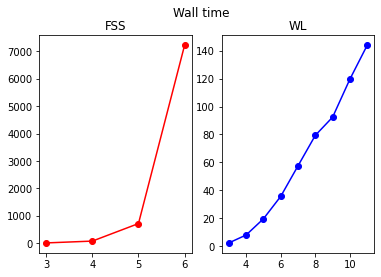

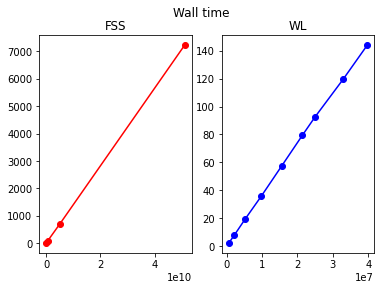

In [13]:
# Wall time comparison

fig = plt.figure(1)
fig.suptitle("Wall time")

plt.subplot(121)
plt.plot(REP_exp_vals, wall_time_mean_fss, marker='o', color='r')
plt.title("FSS")

plt.subplot(122)
plt.plot(f_final_exp_vals, wall_time_mean_wl, marker='o', color='b')
plt.title("WL")

fig = plt.figure(2)
fig.suptitle("Wall time")

plt.subplot(121)
plt.plot(steps_mean_fss, wall_time_mean_fss, marker='o', color='r')
plt.title("FSS")


plt.subplot(122)
plt.plot(steps_mean_wl, wall_time_mean_wl, marker='o', color='b')
plt.title("WL")

plt.show()


In [ ]:
# Plot mean and var for the fitted distribuitions

# Checkerboard

fig = plt.figure(1)
fig.suptitle("Checkerboard")

plt.subplot(121)
plt.errorbar(REP_exp_vals, fit_chkbrd_fss[:, 0], fit_chkbrd_fss[:, 1], marker='.', color='r')
plt.title("FSS")
plt.ylim([1, 3])

plt.subplot(122)
plt.errorbar(f_final_exp_vals, fit_chkbrd_wl[:, 0], fit_chkbrd_wl[:, 1], marker='.', color='b')
plt.title("WL")
plt.ylim([1, 3])

# Slice

fig = plt.figure(2)
fig.suptitle("Slice")

plt.subplot(121)
plt.errorbar(REP_exp_vals, fit_slice_fss[:, 0], fit_slice_fss[:, 1], marker='.', color='r')
plt.title("FSS")
plt.ylim([8, 24])

plt.subplot(122)
plt.errorbar(f_final_exp_vals, fit_slice_wl[:, 0], fit_slice_wl[:, 1], marker='.', color='b')
plt.title("WL")
plt.ylim([8, 24])

plt.show()


In [ ]:
# Variance for both methods

# Checkerboard

fig = plt.figure(1)
fig.suptitle("Checkerboard")

plt.subplot(121)
plt.plot(REP_exp_vals, fit_chkbrd_fss[:, 1], marker='o', color='r')
plt.title("FSS")
plt.ylim([0, 1])

plt.subplot(122)
plt.plot(f_final_exp_vals, fit_chkbrd_wl[:, 1], marker='o', color='b')
plt.title("WL")
plt.ylim([0, 1])

# Slice

fig = plt.figure(2)
fig.suptitle("Slice")

plt.subplot(121)
plt.plot(REP_exp_vals, fit_slice_fss[:, 1], marker='o', color='r')
plt.title("FSS")
plt.ylim([0, 10])

plt.subplot(122)
plt.plot(f_final_exp_vals, fit_slice_wl[:, 1], marker='o', color='b')
plt.title("WL")
plt.ylim([0, 10])

plt.show()


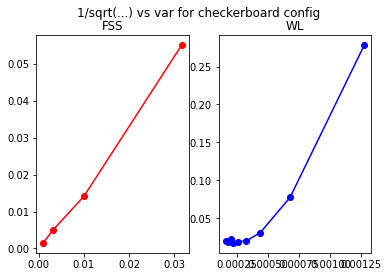

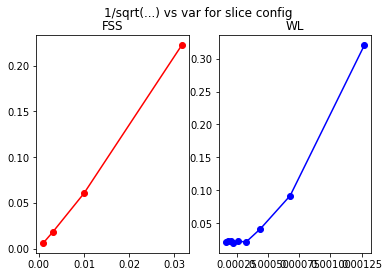

Fit with m=1.6156567701182132; b=-0.00010864880729918175; r2=1.0

Fit with m=-12.198065321605853; b=0.022347697828392413; r2=0.062265904034386976


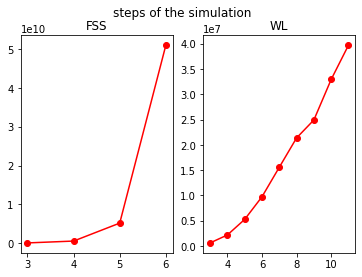

In [8]:
# 1/sqrt(REP) vs var

# Checkerboard

plt.figure(1)

plt.suptitle("1/sqrt(...) vs var for checkerboard config")
plt.subplot(121)
plt.plot(1/np.sqrt(REP_vals), fit_error_chkbrd_fss[:, 1], '-or')
plt.title("FSS")

plt.subplot(122)
plt.plot(1/np.sqrt(steps_mean_wl), fit_error_chkbrd_wl[:, 1], '-ob')
plt.title("WL")

# Slice

plt.figure(2)

plt.suptitle("1/sqrt(...) vs var for slice config")
plt.subplot(121)
plt.plot(1/np.sqrt(REP_vals), fit_error_slice_fss[:, 1], '-or')
plt.title("FSS")

plt.subplot(122)
plt.plot(1/np.sqrt(steps_mean_wl), fit_error_slice_wl[:, 1], '-ob')
plt.title("WL")

plt.show()

x = 1/np.sqrt(REP_vals[2:5])
y = fit_error_chkbrd_fss[2:5, 1]
m, b, r_value, p_value, std_err = linregress(x, y)
print(f"Fit with m={m}; b={b}; r2={r_value**2}")

print()

x = 1/np.sqrt(steps_mean_wl[4:9])
y = fit_error_chkbrd_wl[4:9, 1]
m, b, r_value, p_value, std_err = linregress(x, y)
print(f"Fit with m={m}; b={b}; r2={r_value**2}")

plt.figure(3)

plt.suptitle("steps of the simulation")
plt.subplot(121)
plt.plot(np.log10(REP_vals), steps_mean_fss, '-or')
plt.title("FSS")

plt.subplot(122)
plt.plot(f_final_exp_vals, steps_mean_wl, '-or')
plt.title("WL")

plt.show()


In [ ]:
# Save data to file

with open("wall_time_fss.txt", 'w') as file:
    for i in range(len(REP_vals)):
        file.write(f"{REP_vals[i]} {wall_time_mean_fss[i]} \n")
        
with open("wall_time_wl.txt", 'w') as file:
    for i in range(len(f_final_vals)):
        file.write(f"{f_final_vals[i]} {wall_time_mean_wl[i]} \n")
        
with open("sigma_sqrt_fss.txt", 'w') as file:
    for i in range(len(REP_vals)):
        file.write(f"{REP_vals[i]} {fit_error_chkbrd_fss[i, 1]} {fit_error_slice_fss[i, 1]} \n")
        
with open("sigma_sqrt_wl.txt", 'w') as file:
    for i in range(len(f_final_vals)):
        file.write(f"{steps_mean_wl[i]} {fit_error_chkbrd_wl[i, 1]} {fit_error_slice_wl[i, 1]} \n")

with open("error_fss.txt", 'w') as file:
    for i in range(len(REP_vals)):
        file.write(f"{REP_vals[i]} {mean_abs_error_chkbrd_fss[i]} {fit_error_chkbrd_fss[i, 1]} {mean_abs_error_slice_fss[i]} {fit_error_slice_fss[i, 1]}\n")
        
with open("error_wl.txt", 'w') as file:
    for i in range(1, len(f_final_vals)):
        file.write(f"{f_final_vals[i]} {mean_abs_error_chkbrd_wl[i]} {fit_error_chkbrd_wl[i, 1]} {mean_abs_error_slice_wl[i]} {fit_error_slice_wl[i, 1]}\n")
        